In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['talkingdata-adtracking-fraud-detection', 'train-all-features-sample']


**Read File and Sampling**

Check Number of Record

In [2]:
import subprocess
#from https://stackoverflow.com/questions/845058/how-to-get-line-count-cheaply-in-python , Olafur's answer
def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, 
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])

lines = file_len('../input/talkingdata-adtracking-fraud-detection/train.csv')
print('Number of lines in "train.csv" is:', lines)

Number of lines in "train.csv" is: 184903891


This is a huge file, it will not be able to fit in to memory. We perform EDA on the portion of the file by sampling.
To sample the records - We have to use the skiprows feature in Pandas to read the file to avoid reading all of the content to memory

In [3]:
#Use skip rows feature to randomly exclude the rows -> lines - 1 - sample size
#generate list of lines to skip
skiplines = np.random.choice(np.arange(1, lines), size=lines-1-1000000, replace=False)
#sort the list
skiplines=np.sort(skiplines)
#check our list
print('lines to skip:', len(skiplines))
print('remaining lines in sample:', lines-len(skiplines), '(remember that it includes the heading!)')

lines to skip: 183903890
remaining lines in sample: 1000001 (remember that it includes the heading!)


In [4]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        }
train_data = pd.read_csv('../input/talkingdata-adtracking-fraud-detection/train.csv', skiprows=skiplines, dtype=dtypes)
train_data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
1,166616,3,1,19,379,2017-11-06 15:42:22,NaN,0
2,43668,3,1,19,379,2017-11-06 15:42:37,NaN,0
3,108881,3,1,13,379,2017-11-06 15:46:15,NaN,0
4,172483,3,1,13,379,2017-11-06 15:59:07,NaN,0


In [5]:
import gc
del skiplines
gc.collect()

11

**Exploratory Data Analysis**

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
ip                 1000000 non-null uint32
app                1000000 non-null uint16
device             1000000 non-null uint16
os                 1000000 non-null uint16
channel            1000000 non-null uint16
click_time         1000000 non-null object
attributed_time    2539 non-null object
is_attributed      1000000 non-null uint8
dtypes: object(2), uint16(4), uint32(1), uint8(1)
memory usage: 27.7+ MB


Check Data Quality

In [7]:
missing_val_count_by_column = (train_data.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

attributed_time    997461
dtype: int64


There are many empty values in attributed_time column, we will need to further check this. From below check, we can confirm that when is_attributed is 0, all of the value of attributed_time is not available (value is NaN) which makes sense.

In [8]:
non_attributed = train_data[(train_data['is_attributed'] == 0)]
print('Number of row where is_attributed = 0: ', len(non_attributed[non_attributed['attributed_time'].isnull()]))

Number of row where is_attributed = 0:  997461


However, is_attributed is our target label, so attributed_time will not be available during prediction. The field has to be dropped. 

In [9]:
train_data.drop(['attributed_time'], axis=1, inplace=True)

Let's compare the number of attributed vs non attributed record 

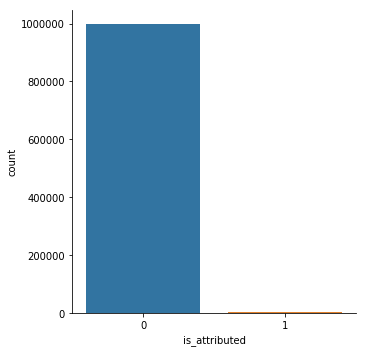

In [10]:
import seaborn as sns
sns.catplot(x="is_attributed", kind="count", data=train_data)

From the bar plot above, we found that it is a highly imbalance dataset, let's calculate the exact conversion rate

In [11]:
def conversion_rate_calc(number_attributed, total):
    return number_attributed/total * 100

conversion_rate = conversion_rate_calc(len(train_data[train_data['is_attributed'] ==1]), len(train_data))
print("Conversion rate = %.3f%%"%conversion_rate)

Conversion rate = 0.254%


Count number of unique value in each category

In [12]:
#Number of unique device, os, ip, channel, app
print("Number of unique IP =", len(pd.unique(train_data['ip'])))
print("Number of unique App =", len(pd.unique(train_data['app'])))
print("Number of unique Device =", len(pd.unique(train_data['device'])))
print("Number of unique OS =", len(pd.unique(train_data['os'])))
print("Number of unique Channel =", len(pd.unique(train_data['channel'])))


Number of unique IP = 81452
Number of unique App = 294
Number of unique Device = 395
Number of unique OS = 207
Number of unique Channel = 173


Let's plot top 10 value and their count for each category

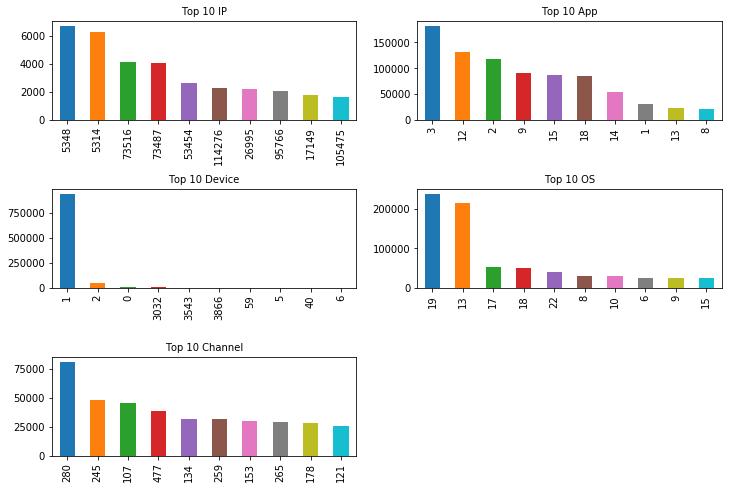

In [13]:
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(3, 2, figsize=(12, 8))
#IP
train_data['ip'].value_counts().head(10).plot.bar(ax=axarr[0,0])
axarr[0,0].set_title("Top 10 IP", fontsize=10)
#APP
train_data['app'].value_counts().head(10).plot.bar(ax=axarr[0,1])
axarr[0,1].set_title("Top 10 App", fontsize=10)
#Device
train_data['device'].value_counts().head(10).plot.bar(ax=axarr[1,0])
axarr[1,0].set_title("Top 10 Device", fontsize=10)
#OS
train_data['os'].value_counts().head(10).plot.bar(ax=axarr[1,1])
axarr[1,1].set_title("Top 10 OS", fontsize=10)
#Channel
train_data['channel'].value_counts().head(10).plot.bar(ax=axarr[2,0])
axarr[2,0].set_title("Top 10 Channel", fontsize=10)
plt.subplots_adjust(hspace=.7)
fig.delaxes(axarr[2,1])

Plot conversion rate in top 10 for each category compare to overall conversion rate

In [14]:
def format_conversion_rate_df(total_series, attributed_dict, column_names):
    top_cat_conversion_rate = np.zeros(shape=(10,3)).astype(object)
    for i, (cat_value, count) in enumerate(total_series.items()):
        top_cat_conversion_rate[i,0] = ",".join(map(str, cat_value)) if type(cat_value) == tuple else cat_value
        top_cat_conversion_rate[i,1] = conversion_rate
        top_cat_conversion_rate[i,2] = conversion_rate_calc(attributed_dict.get(cat_value), count) if attributed_dict.get(cat_value) != None else 0
    top_cat_conversion_rate_df = pd.DataFrame(data=top_cat_conversion_rate[:,1:],    # values
                                index=top_cat_conversion_rate[:,0].astype(str),    # 1st column as index
                                columns=column_names) 
    return top_cat_conversion_rate_df

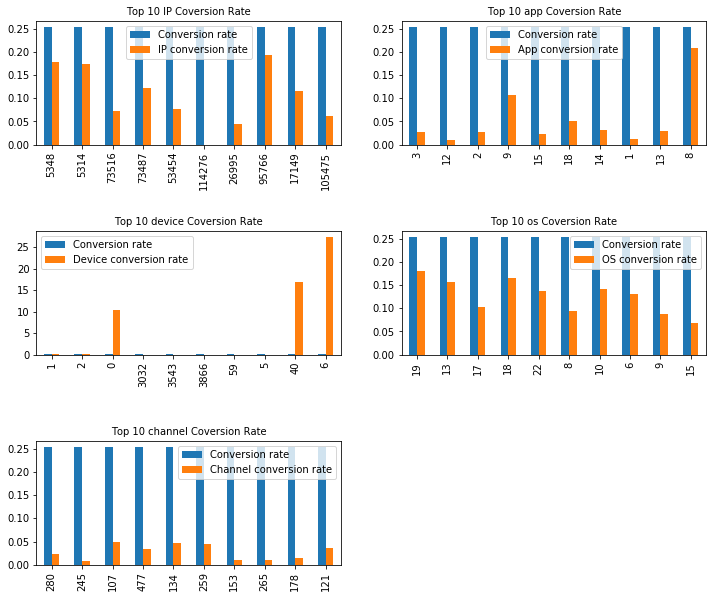

In [15]:
fig, axarr = plt.subplots(3, 2, figsize=(12, 10))

top_10_ip_count = train_data['ip'].value_counts().head(10)
top_10_ip_attributed_dict = train_data[train_data.ip.isin(top_10_ip_count.index.values) & train_data.is_attributed == 1]['ip'].value_counts().to_dict()    
format_conversion_rate_df(top_10_ip_count, top_10_ip_attributed_dict, ['Conversion rate', 'IP conversion rate']).plot.bar(ax=axarr[0,0])
axarr[0,0].set_title("Top 10 IP Coversion Rate", fontsize=10)

top_10_app_count = train_data['app'].value_counts().head(10)
top_10_app_attributed_dict = train_data[train_data.app.isin(top_10_app_count.index.values) & train_data.is_attributed == 1]['app'].value_counts().to_dict()    
format_conversion_rate_df(top_10_app_count, top_10_app_attributed_dict, ['Conversion rate', 'App conversion rate']).plot.bar(ax=axarr[0,1])
axarr[0,1].set_title("Top 10 app Coversion Rate", fontsize=10)

top_10_device_count = train_data['device'].value_counts().head(10)
top_10_device_attributed_dict = train_data[train_data.device.isin(top_10_device_count.index.values) & train_data.is_attributed == 1]['device'].value_counts().to_dict()    
format_conversion_rate_df(top_10_device_count, top_10_device_attributed_dict, ['Conversion rate', 'Device conversion rate']).plot.bar(ax=axarr[1,0])
axarr[1,0].set_title("Top 10 device Coversion Rate", fontsize=10)

top_10_os_count = train_data['os'].value_counts().head(10)
top_10_os_attributed_dict = train_data[train_data.os.isin(top_10_os_count.index.values) & train_data.is_attributed == 1]['os'].value_counts().to_dict()    
format_conversion_rate_df(top_10_os_count, top_10_os_attributed_dict, ['Conversion rate', 'OS conversion rate']).plot.bar(ax=axarr[1,1])
axarr[1,1].set_title("Top 10 os Coversion Rate", fontsize=10)

top_10_channel_count = train_data['channel'].value_counts().head(10)
top_10_channel_attributed_dict = train_data[train_data.channel.isin(top_10_channel_count.index.values) & train_data.is_attributed == 1]['channel'].value_counts().to_dict()    
format_conversion_rate_df(top_10_channel_count, top_10_channel_attributed_dict, ['Conversion rate', 'Channel conversion rate']).plot.bar(ax=axarr[2,0])
axarr[2,0].set_title("Top 10 channel Coversion Rate", fontsize=10)

plt.subplots_adjust(hspace=.7)
fig.delaxes(axarr[2,1])

Let's assume unique source of click is combination of IP, Device and OS. We will plot the top 10 unique source and compare their conversion rate with overall conversion rate. 

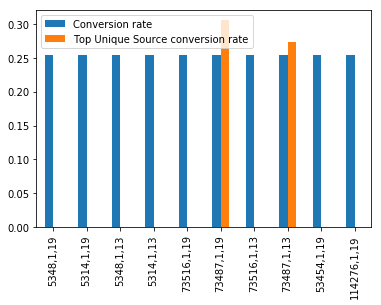

In [16]:
sorted_train_data = train_data.sort_values(['click_time'], ascending=False)
unique_source_grp = sorted_train_data.groupby(['ip', 'device', 'os'])
top_unique_source_series = unique_source_grp.size().sort_values(ascending=False).head(10)
attributed_train_data = train_data[train_data.is_attributed == 1]
attributed_unique_source_grp = attributed_train_data.groupby(['ip', 'device', 'os'])
attributed_unique_source_dict =  attributed_unique_source_grp.size().to_dict() 
format_conversion_rate_df(top_unique_source_series, attributed_unique_source_dict, ['Conversion rate', 'Top Unique Source conversion rate']).plot.bar()

In [17]:
train_data.head()

,ip,app,device,os,channel,click_time,is_attributed
0,35810,3,1,13,379,2017-11-06 14:34:12,0
1,166616,3,1,19,379,2017-11-06 15:42:22,0
2,43668,3,1,19,379,2017-11-06 15:42:37,0
3,108881,3,1,13,379,2017-11-06 15:46:15,0
4,172483,3,1,13,379,2017-11-06 15:59:07,0


Let's examine "click_time" feature, we will first round the time to hour and plot number of click and converion ratio for the time series.

In [18]:
train_data['click_time'] = pd.to_datetime(train_data['click_time'])
train_data['click_round_hour'] = train_data['click_time'].dt.round('H')
train_data.head()

,ip,app,device,os,channel,click_time,is_attributed,click_round_hour
0,35810,3,1,13,379,2017-11-06 14:34:12,0,2017-11-06 15:00:00
1,166616,3,1,19,379,2017-11-06 15:42:22,0,2017-11-06 16:00:00
2,43668,3,1,19,379,2017-11-06 15:42:37,0,2017-11-06 16:00:00
3,108881,3,1,13,379,2017-11-06 15:46:15,0,2017-11-06 16:00:00
4,172483,3,1,13,379,2017-11-06 15:59:07,0,2017-11-06 16:00:00


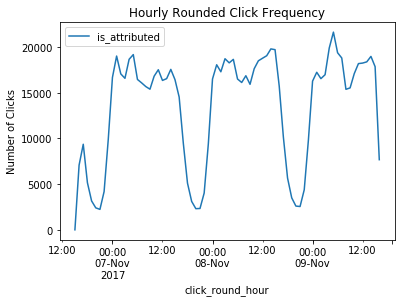

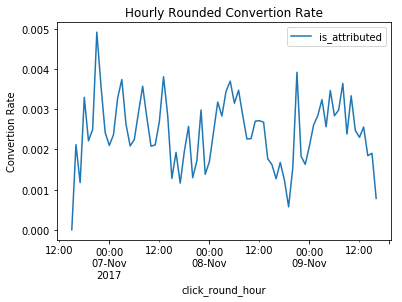

In [19]:
train_data[['click_round_hour','is_attributed']].groupby(['click_round_hour'], as_index=True).count().plot()
plt.title('Hourly Rounded Click Frequency');
plt.ylabel('Number of Clicks');

train_data[['click_round_hour','is_attributed']].groupby(['click_round_hour'], as_index=True).mean().plot()
plt.title('Hourly Rounded Convertion Rate');
plt.ylabel('Convertion Rate');

Next, we extract the hour of the day and explore the click frequency and conversion rate pattern

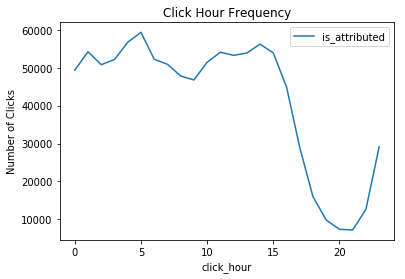

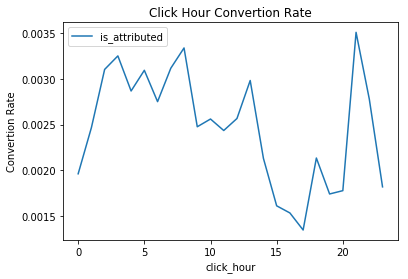

In [20]:
train_data['click_hour'] = train_data['click_time'].dt.round('H').dt.hour
train_data[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot()
plt.title('Click Hour Frequency');
plt.ylabel('Number of Clicks');

train_data[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot()
plt.title('Click Hour Convertion Rate');
plt.ylabel('Convertion Rate');

We will further compare the distribution of the attributed and non attributed vs the click hour using KDE plot

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


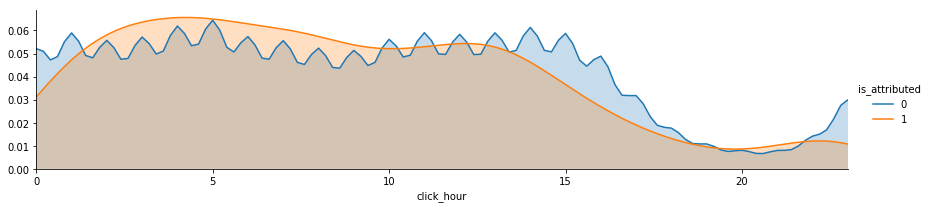

In [21]:
facet = sns.FacetGrid(train_data, hue="is_attributed",aspect=4)
facet.map(sns.kdeplot,'click_hour',shade= True)
facet.set(xlim=(0, train_data['click_hour'].max()))
facet.add_legend()

Intuitively, the frequency of previous click may affect the conversion rate. Let's find out the number of click of a unique source (unique of IP, OS, Device combination) in past 5 minutes and examine the feature.  

In [22]:
train_data['unique_src_cum_count'] = 0
unique_source_grp = train_data.groupby(['ip', 'device', 'os'])
cum_count_df = unique_source_grp['click_time', 'unique_src_cum_count'].rolling('5Min', on='click_time').count()
train_data['unique_src_cum_count'] = cum_count_df.reset_index(level=('ip', 'device', 'os'), drop=True).sort_index()['unique_src_cum_count']

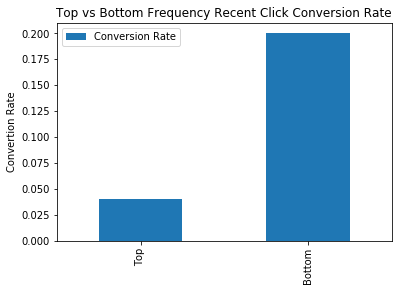

In [23]:
sorted_cum_count_df = train_data.sort_values('unique_src_cum_count', ascending=False)
top_cum_count_df = sorted_cum_count_df.head(10000)
bottom_cum_count_df = sorted_cum_count_df.tail(10000)
top_cum_count_conversion_rate = conversion_rate_calc(len(top_cum_count_df[top_cum_count_df['is_attributed'] ==1]), len(top_cum_count_df)) 
bottom_cum_count_conversion_rate = conversion_rate_calc(len(bottom_cum_count_df[bottom_cum_count_df['is_attributed'] ==1]), len(bottom_cum_count_df)) 
pd.DataFrame({'Conversion Rate':[top_cum_count_conversion_rate, bottom_cum_count_conversion_rate]},    # values
                                index=['Top','Bottom'],   
                                ).plot.bar()
plt.title('Top vs Bottom Frequency Recent Click Conversion Rate');
plt.ylabel('Convertion Rate');

**Feature Engineering**

Armed with knowledge and insight from data exploratory analysis above, now we are able to proceed on feature engineering. In this steps we will: 
* generate new features
* remove existing features which are not related
* remove row in dataset which doesnt have enough example/feature value, this is applied to features IP, Device, OS, Channel, and APP  
* perform transformation on the data if required


The dataset is too big to fit into memory, so we will use Big Query and other Big Data tools to perform some of the steps above. 
First, Big Query is used to generate cumulative count of click by several combinations of IP, Device, OS, Channel and APP.
Assuming, the resulting model will be used for real time prediction, at prediction time the future transaction will not be known. Therefore,
we only generate the culmulative count based on previous records ordered by click time. We perform the culmulative count based on time windows 

* past 5 minutes
* past 5 minutes to 1 hour
* past 1 hour to 8 hour

The value of time windows are defined based on our assumption, we should experiment with the value to find the most optimum one, they should be defined as hyperparameter. However due to processing time and resource limitation, it is not easy to be done here.  

The example result of a new feature will be: in past 5 minutes there are 5 clicks from a source with IP = 123, Device = 5, OS = 4 

Next, we also generate cumulative unique count for a feature versue combination of other features, for example in past 8 hours how many unique app clicked from source with IP = 123, Device = 5, OS = 4

Dataset rows which doesn't have enough example/feature value are removed by Big Query too.

Then we sample the result dataset and perform some further analysis on the generated features.  



In [24]:
train_all_feature = pd.read_csv("../input/train-all-features-sample/train_all_features_sample.csv.gzip", compression='gzip')

In [25]:
train_all_feature.drop(['random'], axis=1, inplace=True)
train_all_feature.head()

,ip,app,device,os,channel,click_time,is_attributed,cumcount_by_ip_app_past_5min,cumcount_by_ip_app_past_5min_to_1hr,cumcount_by_ip_app_past_1hr_to_8hr,cumcount_by_ip_app_os_past_5min,cumcount_by_ip_app_os_past_5min_to_1hr,cumcount_by_ip_app_os_past_1hr_to_8hr,cumcount_by_ip_device_os_past_5min,cumcount_by_ip_device_os_past_5min_to_1hr,cumcount_by_ip_device_os_past_1hr_to_8hr,cumcount_by_ip_device_os_app_past_5min,cumcount_by_ip_device_os_app_past_5min_to_1hr,cumcount_by_ip_device_os_app_past_1hr_to_8hr,cumcount_by_ip_device_os_app_channel_past_5min,cumcount_by_ip_device_os_app_channel_past_5min_to_1hr,cumcount_by_ip_device_os_app_channel_past_1hr_to_8hr,unique_channel_by_ip_cum_count,unique_app_by_ip_device_os_cum_count,unique_app_by_ip_cum_count,unique_channel_by_ip_device_os_cum_count
0,59441,3,1,16,280,2017-11-09 14:24:02 UTC,0,9,84,1023,3,1,19,7,1,92,3,1,17,2,1,8,96,11,38,15
1,72315,21,1,13,128,2017-11-07 08:38:22 UTC,0,2,1,4,2,0,0,2,0,110,2,0,0,2,0,0,70,18,33,46
2,31161,18,1,13,107,2017-11-07 17:49:53 UTC,0,1,3,10,1,3,8,1,3,76,1,3,8,1,3,3,51,15,26,36
3,88911,13,1,19,477,2017-11-07 09:29:01 UTC,0,1,1,27,1,0,11,4,11,364,1,0,11,1,0,10,81,27,33,71
4,96592,21,1,6,128,2017-11-09 06:16:41 UTC,0,1,2,30,1,0,5,1,0,44,1,0,5,1,0,5,85,15,34,26


In [26]:
train_all_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
ip                                                       1000000 non-null int64
app                                                      1000000 non-null int64
device                                                   1000000 non-null int64
os                                                       1000000 non-null int64
channel                                                  1000000 non-null int64
click_time                                               1000000 non-null object
is_attributed                                            1000000 non-null int64
cumcount_by_ip_app_past_5min                             1000000 non-null int64
cumcount_by_ip_app_past_5min_to_1hr                      1000000 non-null int64
cumcount_by_ip_app_past_1hr_to_8hr                       1000000 non-null int64
cumcount_by_ip_app_os_past_5min                          1000000 non-null int64
cumcoun

In [27]:
# round the time, this actually should be done in Big query
train_all_feature['click_time'] = pd.to_datetime(train_all_feature['click_time'])
train_all_feature['click_hour'] = train_all_feature['click_time'].dt.round('H').dt.hour
#click time is removed
train_all_feature.drop(['click_time'], axis=1, inplace=True)

We will examine the numeric features and target variable below

In [28]:
corrmat = train_all_feature.loc[:, 'is_attributed':'unique_app_by_ip_cum_count'].corr()

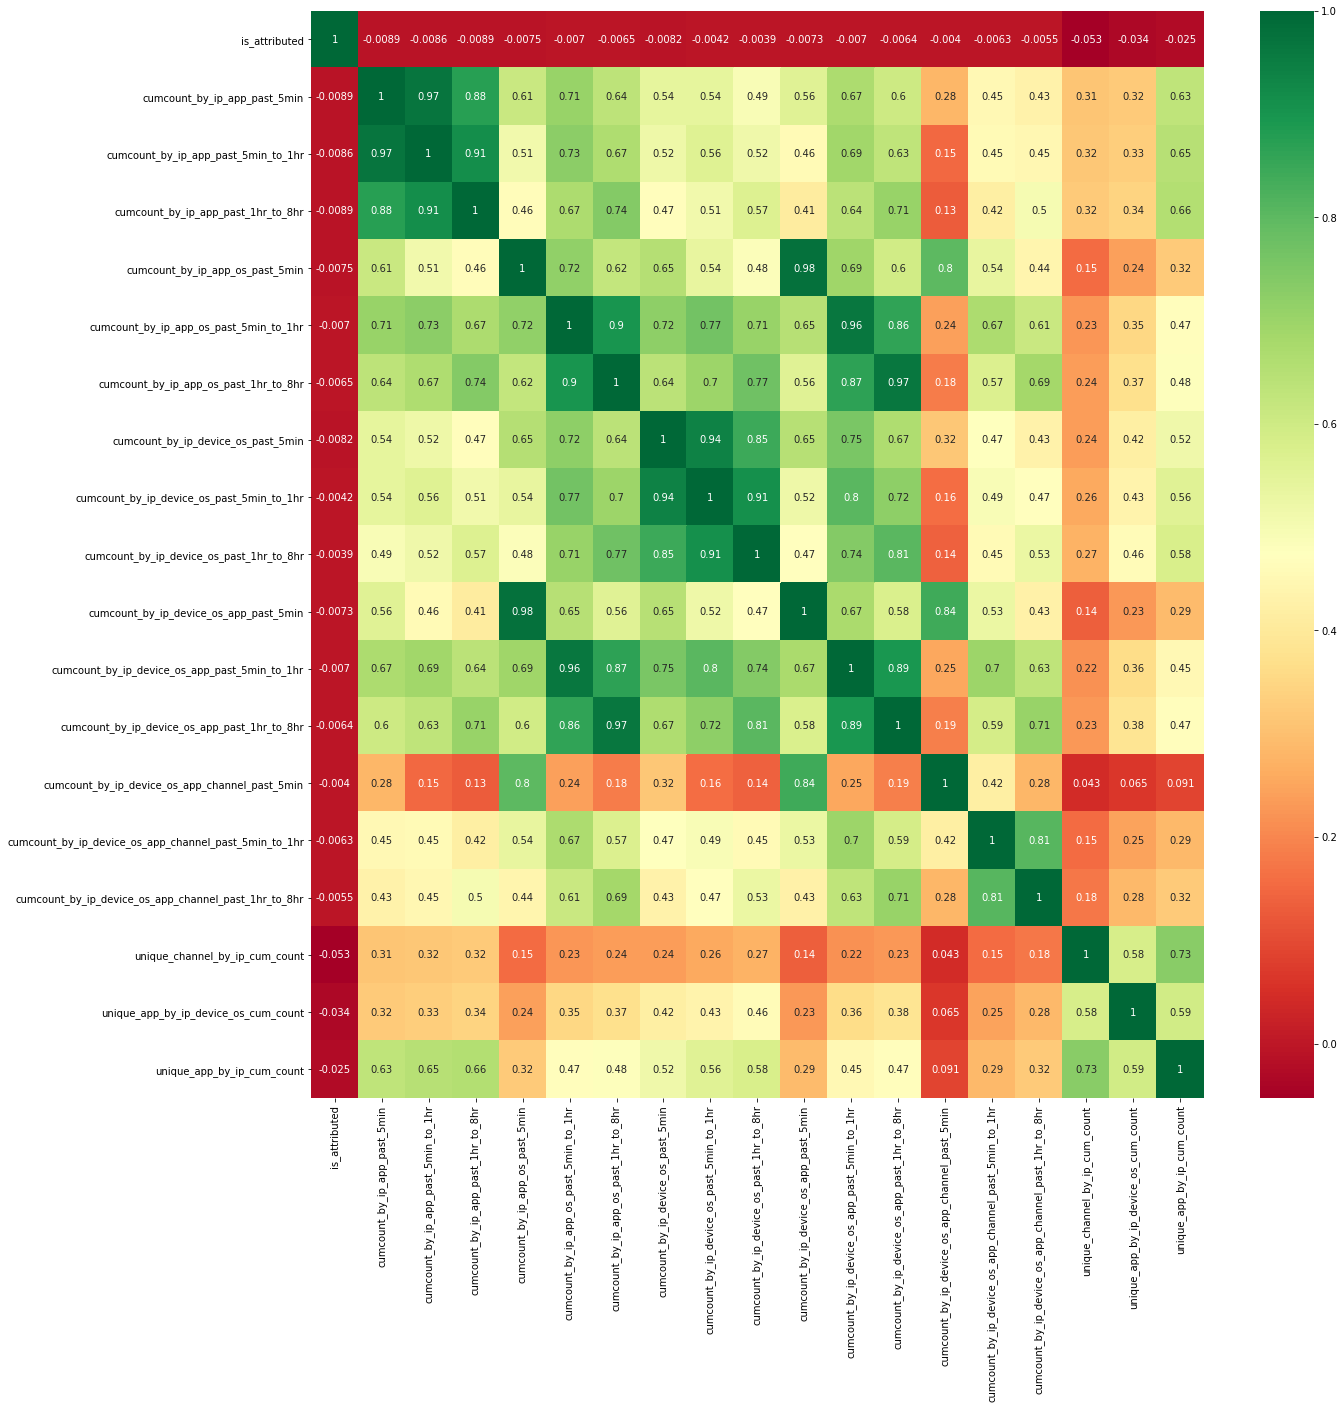

In [29]:
plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, annot=True, cmap="RdYlGn")

We will remove features which have high correlation with other features i.e greater than 0.95 in correlation score. 


In [30]:
#list down the feature pair with correlation score > 0.95 
for index, row in corrmat.iterrows():
    if len(row[(row > 0.95) & (row < 1.0)]) > 0:
        print(index + ' VS :')
        print(row[(row > 0.95) & (row < 1.0)])

cumcount_by_ip_app_past_5min VS :
cumcount_by_ip_app_past_5min_to_1hr    0.970855
Name: cumcount_by_ip_app_past_5min, dtype: float64
cumcount_by_ip_app_past_5min_to_1hr VS :
cumcount_by_ip_app_past_5min    0.970855
Name: cumcount_by_ip_app_past_5min_to_1hr, dtype: float64
cumcount_by_ip_app_os_past_5min VS :
cumcount_by_ip_device_os_app_past_5min    0.978503
Name: cumcount_by_ip_app_os_past_5min, dtype: float64
cumcount_by_ip_app_os_past_5min_to_1hr VS :
cumcount_by_ip_device_os_app_past_5min_to_1hr    0.964258
Name: cumcount_by_ip_app_os_past_5min_to_1hr, dtype: float64
cumcount_by_ip_app_os_past_1hr_to_8hr VS :
cumcount_by_ip_device_os_app_past_1hr_to_8hr    0.966254
Name: cumcount_by_ip_app_os_past_1hr_to_8hr, dtype: float64
cumcount_by_ip_device_os_app_past_5min VS :
cumcount_by_ip_app_os_past_5min    0.978503
Name: cumcount_by_ip_device_os_app_past_5min, dtype: float64
cumcount_by_ip_device_os_app_past_5min_to_1hr VS :
cumcount_by_ip_app_os_past_5min_to_1hr    0.964258
Name: cumco

In [31]:

train_all_feature.drop(['cumcount_by_ip_app_past_5min_to_1hr', 'cumcount_by_ip_device_os_app_past_5min', 'cumcount_by_ip_device_os_app_past_5min_to_1hr',
                       'cumcount_by_ip_device_os_app_past_1hr_to_8hr', 
                       'unique_channel_by_ip_device_os_cum_count'], axis=1, inplace=True)

In [32]:
train_all_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 21 columns):
ip                                                       1000000 non-null int64
app                                                      1000000 non-null int64
device                                                   1000000 non-null int64
os                                                       1000000 non-null int64
channel                                                  1000000 non-null int64
is_attributed                                            1000000 non-null int64
cumcount_by_ip_app_past_5min                             1000000 non-null int64
cumcount_by_ip_app_past_1hr_to_8hr                       1000000 non-null int64
cumcount_by_ip_app_os_past_5min                          1000000 non-null int64
cumcount_by_ip_app_os_past_5min_to_1hr                   1000000 non-null int64
cumcount_by_ip_app_os_past_1hr_to_8hr                    1000000 non-null int64
cumcount

Let's plot histogram to show distribution of the data

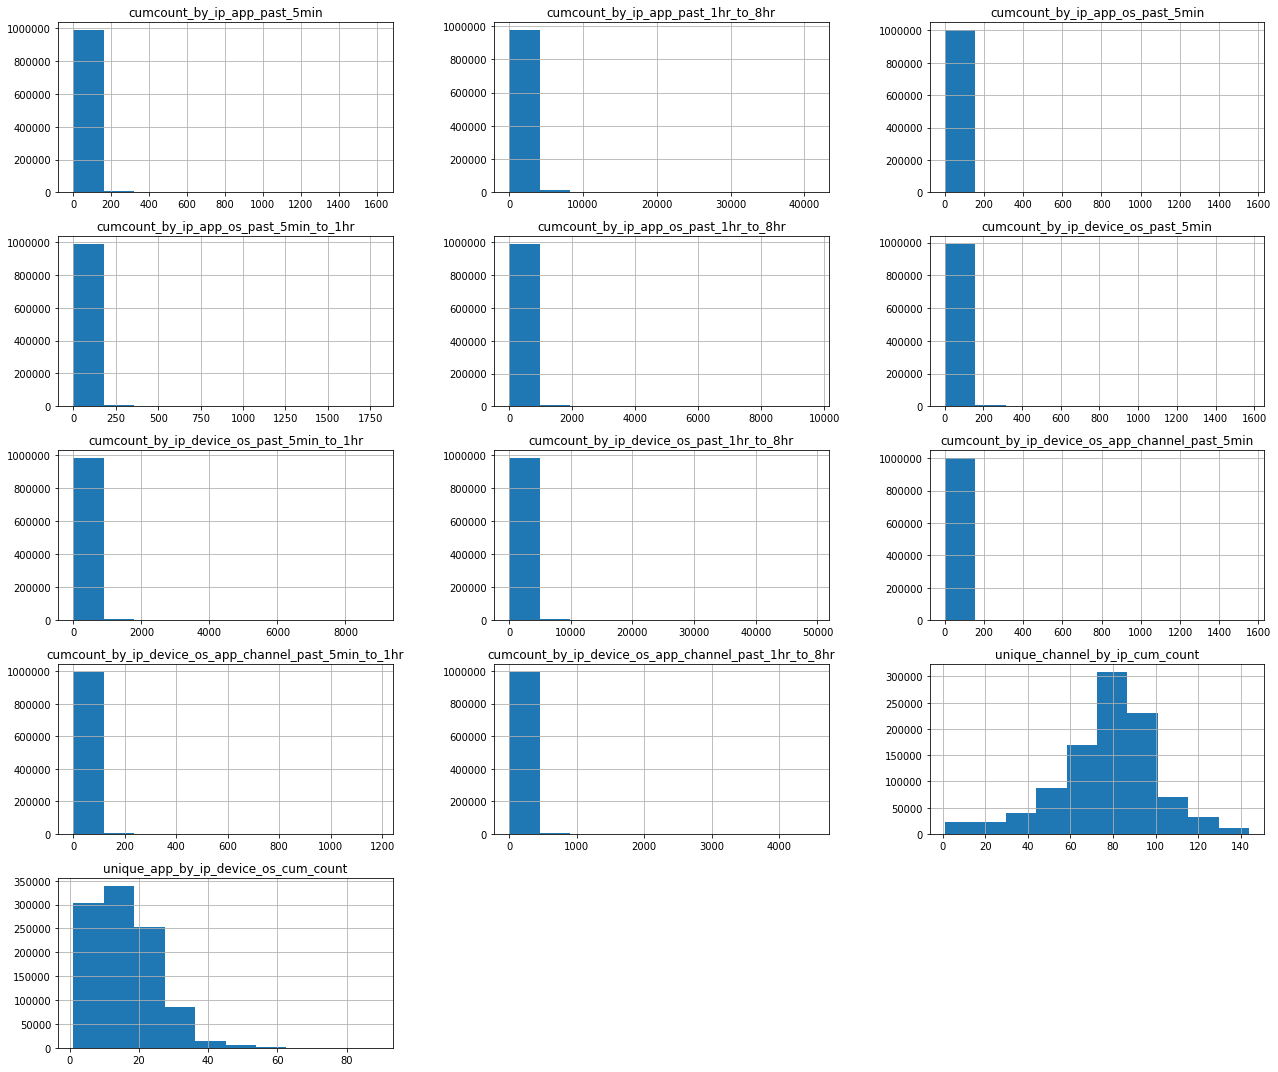

In [33]:
import math
fig, axarr = plt.subplots(5, 3, figsize=(18, 15))
numeric_feature_cols =  train_all_feature.columns.values[6:-1]
for count, numeric_colum in enumerate(numeric_feature_cols):    
    train_all_feature.hist(column=numeric_colum, ax=axarr[math.floor(count/3),count%3])
fig.tight_layout()
fig.delaxes(axarr[4,2])
fig.delaxes(axarr[4,1])

By observing the distribution of the data, we will apply Log transformation to columns with prefix cum_count and Z-Score transformation to colums with prefix unique

In [34]:
# Log Transform
train_all_feature.loc[:, 'cumcount_by_ip_app_past_5min':'cumcount_by_ip_device_os_app_channel_past_1hr_to_8hr'] = np.log(train_all_feature.loc[:, 'cumcount_by_ip_app_past_5min':'cumcount_by_ip_device_os_app_channel_past_1hr_to_8hr']+1)

In [35]:
# Z-Score Transform
from sklearn.preprocessing import StandardScaler
train_all_feature.loc[:, 'unique_channel_by_ip_cum_count':'unique_app_by_ip_cum_count'] = StandardScaler().fit_transform(train_all_feature.loc[:, 'unique_channel_by_ip_cum_count':'unique_app_by_ip_cum_count'])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [36]:
train_all_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 21 columns):
ip                                                       1000000 non-null int64
app                                                      1000000 non-null int64
device                                                   1000000 non-null int64
os                                                       1000000 non-null int64
channel                                                  1000000 non-null int64
is_attributed                                            1000000 non-null int64
cumcount_by_ip_app_past_5min                             1000000 non-null float64
cumcount_by_ip_app_past_1hr_to_8hr                       1000000 non-null float64
cumcount_by_ip_app_os_past_5min                          1000000 non-null float64
cumcount_by_ip_app_os_past_5min_to_1hr                   1000000 non-null float64
cumcount_by_ip_app_os_past_1hr_to_8hr                    1000000 non-null float6

In [37]:
train_all_feature.loc[:, 'cumcount_by_ip_app_past_5min':'cumcount_by_ip_device_os_app_channel_past_1hr_to_8hr'].columns.values

array(['cumcount_by_ip_app_past_5min',
       'cumcount_by_ip_app_past_1hr_to_8hr',
       'cumcount_by_ip_app_os_past_5min',
       'cumcount_by_ip_app_os_past_5min_to_1hr',
       'cumcount_by_ip_app_os_past_1hr_to_8hr',
       'cumcount_by_ip_device_os_past_5min',
       'cumcount_by_ip_device_os_past_5min_to_1hr',
       'cumcount_by_ip_device_os_past_1hr_to_8hr',
       'cumcount_by_ip_device_os_app_channel_past_5min',
       'cumcount_by_ip_device_os_app_channel_past_5min_to_1hr',
       'cumcount_by_ip_device_os_app_channel_past_1hr_to_8hr'],
      dtype=object)

In [38]:
train_all_feature.loc[:,'cumcount_by_ip_app_past_5min':'unique_app_by_ip_cum_count'].describe()

,cumcount_by_ip_app_past_5min,cumcount_by_ip_app_past_1hr_to_8hr,cumcount_by_ip_app_os_past_5min,cumcount_by_ip_app_os_past_5min_to_1hr,cumcount_by_ip_app_os_past_1hr_to_8hr,cumcount_by_ip_device_os_past_5min,cumcount_by_ip_device_os_past_5min_to_1hr,cumcount_by_ip_device_os_past_1hr_to_8hr,cumcount_by_ip_device_os_app_channel_past_5min,cumcount_by_ip_device_os_app_channel_past_5min_to_1hr,cumcount_by_ip_device_os_app_channel_past_1hr_to_8hr,unique_channel_by_ip_cum_count,unique_app_by_ip_device_os_cum_count,unique_app_by_ip_cum_count
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1.000000e+06
mean,1.482365,3.960055,1.046789,1.016123,1.803375,1.966207,2.291269,3.596112,0.888282,0.505558,0.869080,2.061764e-15,9.836685e-16,1.480865e-16
std,1.001748,2.011319,0.587465,1.294857,1.769122,0.975485,1.881657,2.236823,0.449307,0.952529,1.316678,1.000001e+00,1.000001e+00,1.000000e+00
min,0.693147,0.000000,0.693147,0.000000,0.000000,0.693147,0.000000,0.000000,0.693147,0.000000,0.000000,-3.230953e+00,-1.537950e+00,-1.673387e+00
25%,0.693147,2.708050,0.693147,0.000000,0.000000,1.098612,0.000000,1.945910,0.693147,0.000000,0.000000,-4.790001e-01,-7.915606e-01,-4.978435e-01
50%,1.098612,3.931826,0.693147,0.693147,1.386294,1.791759,2.302585,3.761200,0.693147,0.000000,0.000000,1.137282e-01,-4.517077e-02,-2.039576e-01
75%,1.791759,5.129899,1.098612,1.609438,2.944439,2.564949,3.610918,5.141664,0.693147,0.693147,1.386294,5.794434e-01,7.012191e-01,1.389093e-01
max,7.382124,10.627188,7.349231,7.492760,9.175128,7.362011,9.099185,10.806855,7.348588,7.076654,8.414274,2.823344e+00,7.845236e+00,6.849304e+00


Let's plot again to show the distribution of the data after transformation

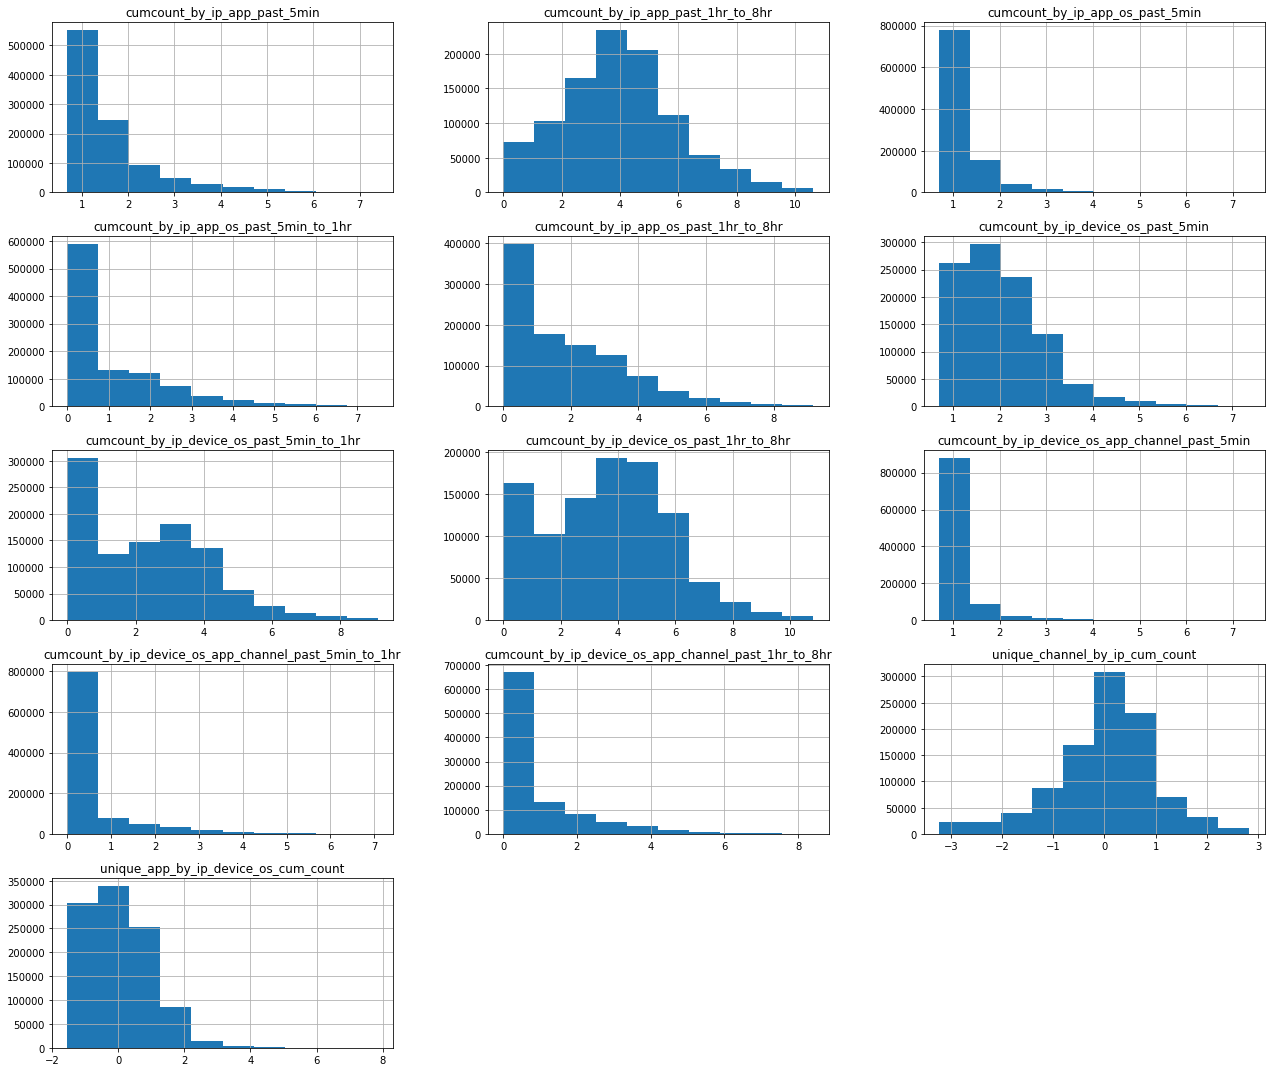

In [39]:
import math
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(5, 3, figsize=(18, 15))
numeric_feature_cols =  train_all_feature.columns.values[6:-1]
for count, numeric_colum in enumerate(numeric_feature_cols):    
    train_all_feature.hist(column=numeric_colum, ax=axarr[math.floor(count/3),count%3])
fig.tight_layout()
fig.delaxes(axarr[4,2])
fig.delaxes(axarr[4,1])

The distrubution and range of the data looks better after transformation.

The feature click_hour represents the hour of the day of a click. This is not really a numeric feature but a cyclical feature. It is because hour 0 (mid night) is very close to hour 23 (11 PM) or hour 1 (1 AM). We will transform it using sin and cos trigonometric functions.   

In [40]:
train_all_feature['click_hr_sin'] =  np.sin(train_all_feature.click_hour*(2.*np.pi/24))
train_all_feature['click_hr_cos'] =  np.cos(train_all_feature.click_hour*(2.*np.pi/24))

In [41]:
train_all_feature.drop(['click_hour'], axis=1, inplace=True)

Now, we have to apply transformation to categorical features IP, OS, Device, Channel, APP. These features have to be encoded into numeric format. This is not trivial task as there are many unique feature values as per our finding in EDA stage. Simple approach like One Hot Encoding will not work as it will produce high dimension sparse transformation result. Hence, we will apply a more sophisticated approach, Cat2Vec to convert the categorical features to numeric vector.  

In [42]:
#cat2vec trasform
# Non memory efficient version - process all in current DF
from random import shuffle
from gensim.models import Word2Vec
import random 
import copy

category_columns = ['ip', 'os', 'device', 'channel', 'app']
#dimension
feature_size = 5
#window size, can be configure later
train_window = 7 

def convert_to_cat(df):
    data = copy.deepcopy(df)
    data.reset_index(drop=True, inplace=True)
    for c in list(data.columns.values):
        data[c] = data[c].astype('category')
        data[c].cat.categories = ["%s %s" % (c,g) for g in data[c].cat.categories]        
    return data    
        
def fit_model(df, size, window, min_count=5):   
    cat_list = convert_to_cat(df).values.tolist()
    for i in cat_list:
        shuffle(i) #shuffle each item in the row
    model = Word2Vec(cat_list, size=size, window=window, min_count=min_count, workers=1)      
    return model
    

def transform(model, cats_df, n_cat_feature, cat_feature_size):
    vocab = set(model.wv.index2word)
    all_cat_vec = np.zeros((cats_df.shape[0],n_cat_feature * cat_feature_size), dtype="float64")
    cats_df.reset_index(drop=True, inplace=True)
    cats_df = convert_to_cat(cats_df)
    for index, row in cats_df.iterrows():
        #cat_vec_row = np.zeros((n_cat_feature * cat_feature_size,), dtype="float64")
        for catIndex, catItem in enumerate(row):
            if catItem in vocab:
                startIndex = catIndex * cat_feature_size
                endIndex = (catIndex + 1) * cat_feature_size
                all_cat_vec[index, startIndex : endIndex] = model[catItem]   
                 
    return all_cat_vec    

cat2vec_model = fit_model(train_all_feature[category_columns], feature_size, train_window)


/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [43]:
cat_feature_vec = transform(cat2vec_model, train_all_feature[category_columns], len(category_columns), feature_size)
cat_feature_df = pd.DataFrame(data=cat_feature_vec,    
    columns=["cat_vec_%s"%i for i in range(25)]) 
train_all_feature.drop(columns=category_columns, inplace=True)
train_all_feature = pd.concat([cat_feature_df, train_all_feature], axis=1)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


The original categorical columns are removed and replaced by new transformed columns

In [44]:
train_all_feature.head()

,cat_vec_0,cat_vec_1,cat_vec_2,cat_vec_3,cat_vec_4,cat_vec_5,cat_vec_6,cat_vec_7,cat_vec_8,cat_vec_9,cat_vec_10,cat_vec_11,cat_vec_12,cat_vec_13,cat_vec_14,cat_vec_15,cat_vec_16,cat_vec_17,cat_vec_18,cat_vec_19,cat_vec_20,cat_vec_21,cat_vec_22,cat_vec_23,cat_vec_24,is_attributed,cumcount_by_ip_app_past_5min,cumcount_by_ip_app_past_1hr_to_8hr,cumcount_by_ip_app_os_past_5min,cumcount_by_ip_app_os_past_5min_to_1hr,cumcount_by_ip_app_os_past_1hr_to_8hr,cumcount_by_ip_device_os_past_5min,cumcount_by_ip_device_os_past_5min_to_1hr,cumcount_by_ip_device_os_past_1hr_to_8hr,cumcount_by_ip_device_os_app_channel_past_5min,cumcount_by_ip_device_os_app_channel_past_5min_to_1hr,cumcount_by_ip_device_os_app_channel_past_1hr_to_8hr,unique_channel_by_ip_cum_count,unique_app_by_ip_device_os_cum_count,unique_app_by_ip_cum_count,click_hr_sin,click_hr_cos
0,0.381308,0.209520,-0.736966,0.394913,0.818884,3.102597,-4.214822,-5.848173,-3.111817,5.358815,1.587263,-1.541545,-2.769582,-0.625548,2.752487,-0.426381,3.333265,5.389997,-2.652538,-0.082190,0.840277,3.686058,2.634097,4.686167,-2.359869,0,2.302585,6.931472,1.386294,0.693147,2.995732,2.079442,0.693147,4.532599,1.098612,0.693147,2.197225,0.791132,-0.471679,0.138909,-0.500000,-8.660254e-01
1,0.688902,0.279903,-0.367063,0.151372,0.217755,3.100274,-4.180781,-5.729589,-3.056681,5.285373,1.587263,-1.541545,-2.769582,-0.625548,2.752487,7.830372,6.624680,1.883313,-5.036904,-9.058916,-5.296232,3.811876,5.962471,7.766943,2.858356,0,1.098612,1.609438,1.098612,0.000000,0.000000,1.098612,0.000000,4.709530,1.098612,0.000000,0.000000,-0.309649,0.274711,-0.105996,0.707107,-7.071068e-01
2,0.000000,0.000000,0.000000,0.000000,0.000000,3.100274,-4.180781,-5.729589,-3.056681,5.285373,1.587263,-1.541545,-2.769582,-0.625548,2.752487,-6.046630,9.318068,-0.812059,-1.181060,-0.583008,-4.166042,2.828818,6.010862,6.534424,2.501971,0,0.693147,2.397895,0.693147,1.386294,2.197225,0.693147,1.386294,4.343805,0.693147,1.386294,1.386294,-1.114066,-0.045171,-0.448863,-1.000000,-1.836970e-16
3,0.464892,0.311655,-0.348408,0.307016,0.565616,3.092805,-4.180478,-5.773361,-3.045013,5.320352,1.587263,-1.541545,-2.769582,-0.625548,2.752487,1.631038,-2.177423,10.200660,3.276458,2.031655,-6.110621,9.996553,-1.161791,4.005009,-1.599204,0,0.693147,3.332205,0.693147,0.000000,2.484907,1.609438,2.484907,5.899897,0.693147,0.000000,2.397895,0.156066,1.234355,-0.105996,0.707107,-7.071068e-01
4,0.703978,0.141195,-0.361658,0.358144,0.632334,2.915046,-4.045206,-5.628909,-2.949526,5.252726,1.587263,-1.541545,-2.769582,-0.625548,2.752487,7.830372,6.624680,1.883313,-5.036904,-9.058916,-5.296232,3.811876,5.962471,7.766943,2.858356,0,0.693147,3.433987,0.693147,0.000000,1.791759,0.693147,0.000000,3.806662,0.693147,0.000000,1.791759,0.325417,-0.045171,-0.057015,1.000000,6.123234e-17


In [45]:
train_all_feature.describe()

,cat_vec_0,cat_vec_1,cat_vec_2,cat_vec_3,cat_vec_4,cat_vec_5,cat_vec_6,cat_vec_7,cat_vec_8,cat_vec_9,cat_vec_10,cat_vec_11,cat_vec_12,cat_vec_13,cat_vec_14,cat_vec_15,cat_vec_16,cat_vec_17,cat_vec_18,cat_vec_19,cat_vec_20,cat_vec_21,cat_vec_22,cat_vec_23,cat_vec_24,is_attributed,cumcount_by_ip_app_past_5min,cumcount_by_ip_app_past_1hr_to_8hr,cumcount_by_ip_app_os_past_5min,cumcount_by_ip_app_os_past_5min_to_1hr,cumcount_by_ip_app_os_past_1hr_to_8hr,cumcount_by_ip_device_os_past_5min,cumcount_by_ip_device_os_past_5min_to_1hr,cumcount_by_ip_device_os_past_1hr_to_8hr,cumcount_by_ip_device_os_app_channel_past_5min,cumcount_by_ip_device_os_app_channel_past_5min_to_1hr,cumcount_by_ip_device_os_app_channel_past_1hr_to_8hr,unique_channel_by_ip_cum_count,unique_app_by_ip_device_os_cum_count,unique_app_by_ip_cum_count,click_hr_sin,click_hr_cos
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000
mean,0.624380,0.063204,-0.591201,0.304683,0.710850,2.946243,-4.065160,-5.669356,-3.029126,5.329048,1.514386,-1.481289,-2.700662,-0.617066,2.784714,0.516154,3.867438,5.598261,-2.195997,-1.132679,-0.225011,4.673332,2.908532,4.555780,-1.969207,0.001958,1.482365,3.960055,1.046789,1.016123,1.803375,1.966207,2.291269,3.596112,0.888282,0.505558,0.869080,2.061764e-15,9.836685e-16,1.480865e-16,0.237626,-0.119947
std,0.454846,0.354347,0.670646,0.208079,0.584409,0.977136,0.822149,0.748236,0.328077,0.364304,0.905582,0.551412,0.518519,0.102265,0.623512,4.323175,4.468346,5.010692,3.086350,3.249433,3.224319,3.480846,4.084848,2.288782,3.744714,0.044206,1.001748,2.011319,0.587465,1.294857,1.769122,0.975485,1.881657,2.236823,0.449307,0.952529,1.316678,1.000001e+00,1.000001e+00,1.000000e+00,0.626884,0.732232
min,-0.451489,-1.216346,-2.548555,-0.220522,-0.054676,-6.052044,-4.510676,-6.261228,-3.477519,0.000000,-7.400015,-1.567710,-2.769582,-1.024249,0.000000,-10.325400,-3.177254,-6.223044,-9.179075,-9.058916,-7.532850,-2.314067,-6.007610,-3.041543,-10.059094,0.000000,0.693147,0.000000,0.693147,0.000000,0.000000,0.693147,0.000000,0.000000,0.693147,0.000000,0.000000,-3.230953e+00,-1.537950e+00,-1.673387e+00,-1.000000,-1.000000
25%,0.321871,0.000000,-0.811435,0.169688,0.326576,3.038480,-4.180781,-5.773361,-3.074389,5.285373,1.587263,-1.541545,-2.769582,-0.625548,2.752487,-2.502394,0.403382,0.723805,-4.696227,-3.604811,-3.787666,2.828818,-0.962413,3.309482,-5.962281,0.000000,0.693147,2.708050,0.693147,0.000000,0.000000,1.098612,0.000000,1.945910,0.693147,0.000000,0.000000,-4.790001e-01,-7.915606e-01,-4.978435e-01,-0.258819,-0.866025
50%,0.520704,0.181628,-0.341789,0.315711,0.554669,3.092805,-4.180478,-5.754469,-3.056681,5.313628,1.587263,-1.541545,-2.769582,-0.625548,2.752487,0.546138,3.333265,6.396956,-2.547024,-0.583008,0.840277,3.686058,2.634097,4.686167,-1.763936,0.000000,1.098612,3.931826,0.693147,0.693147,1.386294,1.791759,2.302585,3.761200,0.693147,0.000000,0.000000,1.137282e-01,-4.517077e-02,-2.039576e-01,0.258819,-0.258819
75%,0.826710,0.283250,-0.104331,0.444788,0.920230,3.100274,-4.129878,-5.729589,-3.045013,5.358815,1.587263,-1.541545,-2.769582,-0.625548,2.752487,3.173768,8.106318,10.200660,-0.688583,1.212180,1.775340,7.411037,6.010862,6.534424,1.287099,0.000000,1.791759,5.129899,1.098612,1.609438,2.944439,2.564949,3.610918,5.141664,0.693147,0.693147,1.386294,5.794434e-01,7.012191e-01,1.389093e-01,0.866025,0.707107
max,2.112145,0.656471,0.276052,1.248875,2.844478,3.302699,3.437486,2.404273,1

Let's plot transformed vector and label it with target

/opt/conda/lib/python3.6/site-packages/hypertools/plot/__init__.py:10: UserWarning: Could not switch backend to TkAgg.  This may impact performance of the plotting functions.
  warnings.warn('Could not switch backend to TkAgg.  This may impact performance of the plotting functions.')


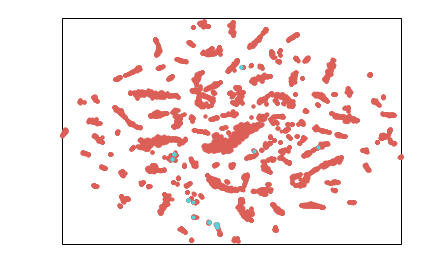

In [46]:
#do some plottint tsne
import hypertools as hyp
train_label = train_all_feature.pop('is_attributed')
hyp.plot(train_all_feature.values[:10000,0:25], '.', reduce='TSNE', hue=train_label.values[:10000], ndims=2)

Our final step in feature engineering stage is to show the featue importance. This can be done by fitting data to a Tree Based classifier and print the feature importance of the model

In [47]:
#feature importance with extra tree
from sklearn.ensemble import ExtraTreesClassifier
claasifier = ExtraTreesClassifier()
claasifier.fit(train_all_feature, train_label)


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [48]:
print(sorted(zip(map(lambda x: round(x, 4), claasifier.feature_importances_), train_all_feature.columns.values), 
             reverse=True))

[(0.0565, 'unique_app_by_ip_cum_count'), (0.0529, 'unique_channel_by_ip_cum_count'), (0.0463, 'cat_vec_23'), (0.0452, 'click_hr_cos'), (0.0415, 'click_hr_sin'), (0.0394, 'cat_vec_22'), (0.0393, 'cat_vec_20'), (0.037, 'cat_vec_19'), (0.0322, 'cat_vec_21'), (0.0298, 'cumcount_by_ip_device_os_past_5min'), (0.0292, 'cat_vec_15'), (0.0282, 'cat_vec_4'), (0.028, 'unique_app_by_ip_device_os_cum_count'), (0.0274, 'cat_vec_3'), (0.0271, 'cat_vec_0'), (0.0269, 'cat_vec_24'), (0.0265, 'cumcount_by_ip_app_past_1hr_to_8hr'), (0.0262, 'cat_vec_7'), (0.0261, 'cat_vec_2'), (0.0257, 'cat_vec_1'), (0.0247, 'cat_vec_16'), (0.0237, 'cumcount_by_ip_device_os_past_1hr_to_8hr'), (0.0229, 'cat_vec_8'), (0.0225, 'cat_vec_5'), (0.0222, 'cumcount_by_ip_device_os_past_5min_to_1hr'), (0.0212, 'cat_vec_6'), (0.0209, 'cat_vec_17'), (0.0201, 'cat_vec_9'), (0.02, 'cat_vec_18'), (0.016, 'cumcount_by_ip_app_past_5min'), (0.0129, 'cumcount_by_ip_app_os_past_1hr_to_8hr'), (0.0116, 'cumcount_by_ip_app_os_past_5min'), (0.01

Features related to "cumulative unique count for a feature versue combination of other features" appear to be important compare to other features, we should consider adding more similar features (more permutation on the feature combination). We can proceed to model development and training as next step. However, note that machine learning development workflow is iteractive, we can come back to revisit this again for example adding/removing features, further transformation and etc until we get good enough model. 